In [1]:
import os
import sys
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt, ticker
from cvxopt import matrix, sparse
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, ptime, plot as pp, utils as ut, network as pnet
from pysar.utils.solvers import l1reg_lstsq
#from pysar.unwrap_error_phase_closure import correct_unwrap_error_closure

work_dir = os.path.expandvars('$PNOTE/sim_phaseClosure')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# reference file
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
sensor_name = sensor.project_name2sensor_name(proj_dir)[0]
ts_file = os.path.join(proj_dir, 'timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')

# specified time-series displacement
tbase = np.array(ts_obj.tbase)
ts_sim = sim.sim_variable_timeseries(tbase, display=False)
inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200
L = 3 * 9

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure
write baseline list info to file: bl_list.txt


generating ifgram stack with decorrelation noise and unwrapping errors ...
ifgram with unwrap error: 0.2
unwrap error jump in 2*pi*(-2, 2): 
number of ifgrams with unwrap error: 95
saved to pickle file sim_ifgram4phaseClosure.pickle.
number of acquisitions: 98
number of sequential connections: 5
number of ifgrams: 475
number of triplets: 940


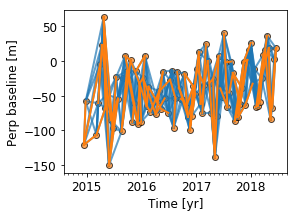

In [20]:
# Network Setup
re_generate = False
num_conn = 5
pfile = 'sim_ifgram4phaseClosure.pickle'
if not os.path.isfile(pfile) or re_generate:
    print('generating ifgram stack with decorrelation noise and unwrapping errors ...')
    # simulate ifgram without unwrap error
    date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
    ifgram_sim = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid, L=3*9, num_sample=1, baseline_file='bl_list.txt', sensor_name=sensor_name, inc_angle=inc_angle)[0].flatten()
    # add unwrap error
    ifgram_err, idx_ifg_err = sim.add_unw_err2ifgram(ifgram_sim, percentage=0.2, Nmax=2, print_msg=True)

    # save to pickle file
    ds = {}
    ds['date12_list'] = date12_list
    ds['ifgram_sim'] = ifgram_sim
    ds['ifgram_err'] = ifgram_err
    ds['idx_ifg_err'] = idx_ifg_err
    with open(pfile, 'wb') as f:
        pickle.dump(ds, f)
    print('saved to pickle file {}.'.format(pfile))
    ds = dict(ds)
else:
    # read pickle file
    print('reading existed pickle file:', pfile)
    with open(pfile, 'rb') as f:
        ds = pickle.load(f)
    date12_list = ds['date12_list']
    ifgram_sim = ds['ifgram_sim']
    ifgram_err = ds['ifgram_err']
    idx_ifg_err = ds['idx_ifg_err']

num_ifgram = len(date12_list)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
print('number of acquisitions: {}'.format(len(ts_obj.dateList)))
print('number of sequential connections: {}'.format(num_conn))
print('number of ifgrams: {}'.format(num_ifgram))
print('number of triplets: {}'.format(C.shape[0]))

# plot
fig, ax = plt.subplots(figsize=[4, 3])
# 1. plot acquisitions
ax.plot(ts_obj.times, ts_obj.pbase, 'ko', alpha=0.7, ms=6, mfc=pp.mplColors[1])
# 2. plot all interferometric pairs
for date12 in date12_list:
    date1, date2 = date12.split('_')
    idx1 = ts_obj.dateList.index(date1)
    idx2 = ts_obj.dateList.index(date2)
    x = [ts_obj.times[idx1], ts_obj.times[idx2]]
    y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
    ax.plot(x, y, '-', lw=2, alpha=0.7, c=pp.mplColors[0])
# 3. plot interferometric pairs with error
for date12 in np.array(date12_list)[idx_ifg_err]:
    date1, date2 = date12.split('_')
    idx1 = ts_obj.dateList.index(date1)
    idx2 = ts_obj.dateList.index(date2)
    x = [ts_obj.times[idx1], ts_obj.times[idx2]]
    y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
    ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
# axis format
pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
ax.set_xlabel('Time [yr]', fontsize=font_size)
ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
plt.show()

In [21]:
## Correct unwrapping error based on the phase closure
ifgram = np.array(ifgram_err)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list).astype(float)
num_tri, num_ifgram = C.shape
ifgram = ifgram.reshape(num_ifgram, -1)

# 1. calculate the integer ambiguity of the closure phase
closure_pha = np.dot(C, ifgram)
closure_int = np.round((closure_pha - ut.wrap(closure_pha)) / (2.*np.pi))

# 2. solve the integer ambiguity using LASSO regression
A = matrix(-C)
b = matrix(closure_int)
U = np.round(l1reg_lstsq(A, b, lambd=1e-2))

# 3. correct unwrap error
ifgram_cor = ifgram + 2.0*np.pi*U
ifgram_cor = ifgram_cor.flatten()

# error percentage
perc0 = np.sum(np.abs(ifgram_err - ifgram_sim) > 0.1) / num_ifgram
perc1 = np.sum(np.abs(ifgram_cor - ifgram_sim) > 0.1) / num_ifgram
print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))

Error percentage: 0.20 -> 0.02


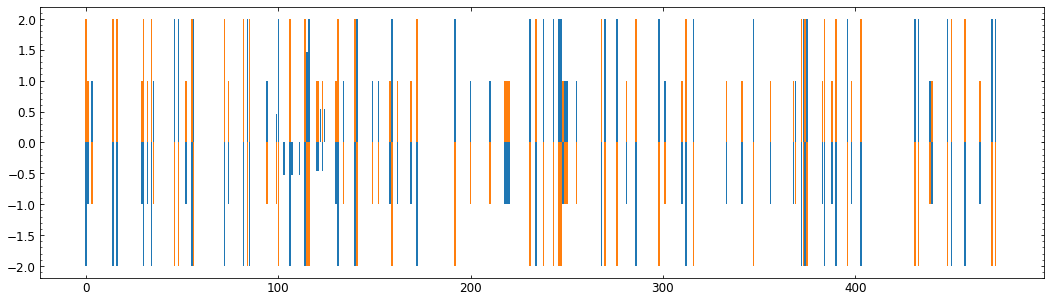

In [22]:
# error (orange) / solution (blue) without rounding.
x = np.array(l1reg_lstsq(A, b, lambd=1e-2)).flatten()
fig, ax = plt.subplots(figsize=[18, 5])
ax.bar(np.arange(x.size), (ifgram_err - ifgram_sim) / (2.0*np.pi), color=pp.mplColors[1], label='error before')
ax.bar(np.arange(x.size), x)
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
plt.show()

saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure/phaseClosure_err_dist.png


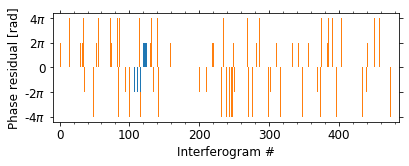

In [26]:
## Fig. 4a - unwrapping-error interferogram number before / after the correction.
fig, ax = plt.subplots(figsize=[6.2, 2])
wid = 1
x = np.arange(num_ifgram)+1 - wid/2.
ax.bar(x, ifgram_err - ifgram_sim, width=wid, color=pp.mplColors[1])
ax.bar(x, ifgram_cor - ifgram_sim, width=wid, color=pp.mplColors[0])

# axis format
ax.tick_params(which='both', direction='out', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Phase residual [rad]', fontsize=font_size)
ax.set_xlim(-10, ifgram_sim.shape[0]+10)

# output
out_file = os.path.join(work_dir, 'phaseClosure_err_dist.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

stats_02cycle_03conn.pickle
stats_02cycle_05conn.pickle
stats_02cycle_10conn.pickle
saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure/phaseClosure_performance_redun.png


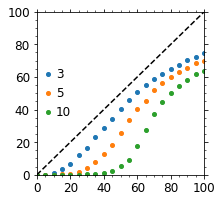

In [45]:
## Fig. 4b - performance as a function of error frequency
fig, ax = plt.subplots(figsize=[3,3])

# plot various number of connections
num_cycle = '02'
for i, num_conn in enumerate(['03', '05', '10']):
    pfile = 'stats_{}cycle_{}conn.pickle'.format(num_cycle, num_conn)
    print(pfile)
    with open(pfile, 'rb') as f:
        ds = pickle.load(f)
    ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i], label=int(num_conn))
    
ax.plot(np.array([0,1]), np.array([0,1]), 'k--')

# axis format
ax.set_xlim(0,1)
ax.set_ylim(0,1)
#ax.yaxis.tick_right()
#ax.yaxis.set_label_position("right")
ax.tick_params(which='both', direction='out', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xticklabels(['{:d}'.format(int(x*100.)) for x in ax.get_xticks()])
ax.set_yticklabels(['{:d}'.format(int(x*100.)) for x in ax.get_yticks()])
ax.legend(loc='center left', frameon=False, fontsize=font_size, borderaxespad=-0.5, handletextpad=-0.3)

# save
out_file = os.path.join(work_dir, 'phaseClosure_performance_redun.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

stats_02cycle_05conn.pickle
stats_05cycle_05conn.pickle
stats_10cycle_05conn.pickle
saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure/phaseClosure_performance_maxMag.png


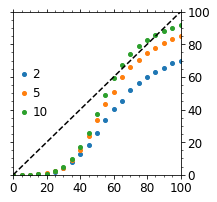

In [46]:
## Fig. 4b - performance as a function of error frequency
fig, ax = plt.subplots(figsize=[3, 3])

# plot various number of connections
num_conn = '05'
for i, num_cycle in enumerate(['02', '05', '10']):
    pfile = 'stats_{}cycle_{}conn.pickle'.format(num_cycle, num_conn)
    print(pfile)
    with open(pfile, 'rb') as f:
        ds = pickle.load(f)
    ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i], label=int(num_cycle))
    
ax.plot(np.array([0,1]), np.array([0,1]), 'k--')

# axis format
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(which='both', direction='out', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xticklabels(['{:d}'.format(int(x*100.)) for x in ax.get_xticks()])
ax.set_yticklabels(['{:d}'.format(int(x*100.)) for x in ax.get_yticks()])
ax.legend(loc='center left', frameon=False, fontsize=font_size, borderaxespad=-0.5, handletextpad=-0.3)

# save
out_file = os.path.join(work_dir, 'phaseClosure_performance_maxMag.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

In [7]:
ds3 = pickle.load(open('stats_02cycle_03conn.pickle', 'rb'))
ds5 = pickle.load(open('stats_02cycle_05conn.pickle', 'rb'))
ds10 = pickle.load(open('stats_02cycle_10conn.pickle', 'rb'))
print('input / output error:')
for i in range(len(ds5['percentage0'])):
    print('{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(ds5['percentage0'][i], ds3['percentage1'][i], ds5['percentage1'][i], ds10['percentage1'][i]))

input / output error:
0.00	0.00	0.00	0.00
0.05	0.00	0.00	0.00
0.10	0.01	0.00	0.00
0.15	0.04	0.00	0.00
0.20	0.07	0.01	0.00
0.25	0.12	0.02	0.00
0.30	0.17	0.04	0.00
0.35	0.23	0.08	0.00
0.40	0.29	0.13	0.01
0.45	0.35	0.18	0.02
0.50	0.41	0.26	0.06
0.55	0.46	0.33	0.09
0.60	0.50	0.40	0.18
0.65	0.55	0.46	0.27
0.70	0.58	0.52	0.37
0.75	0.62	0.56	0.45
0.80	0.65	0.60	0.50
0.85	0.67	0.63	0.55
0.90	0.71	0.66	0.58
0.95	0.72	0.68	0.62
1.00	0.75	0.70	0.64


In [22]:
def correct_unwrap_error_closure(ifgram, C):
    """Estimate unwrapping error from a stack of unwrapped interferometric phase
    Parameters: ifgram : 2D np.array in size of (num_ifgram, num_pixel) of unwrap phase in float32
                C      : 2D np.array in size of (num_triangle, num_ifgram) triangle design matrix in float64
    Returns:    ifgram_cor : 2D np.array in size of (num_ifgram, num_pixel) of unwrap phase after correction
                U          : 2D np.array in size of (num_ifgram, num_pixel) of phase jump integer
    Example:    ifgram_cor, U = estimate_unwrap_error(ifgram, C)
    """
    ifgram = ifgram.reshape(C.shape[1], -1)

    # 1. calculate the integer ambiguity of the closure phase
    closure_pha = np.dot(C, ifgram)
    closure_int = np.round((closure_pha - ut.wrap(closure_pha)) / (2.*np.pi))

    # 2. solve the integer ambiguity using LASSO regression
    A = matrix(-C)
    b = matrix(closure_int)
    U = np.round(l1reg_lstsq(A, b, lambd=1e-2))

    # 3. correct unwrap error
    ifgram_cor = ifgram + 2.0*np.pi*U
    return ifgram_cor, U


def phase_closure_performance(num_conn=3, Nmax=2, step=0.05, num_rep=100):
    # simulate ifgram without unw err
    date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
    num_ifgram = len(date12_list)
    C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list).astype(float)
    #print('number of connections:', num_conn)
    print('number of ifgrams: {}'.format(num_ifgram))
    print('number of triplets: {}'.format(C.shape[0]))

    ifgram = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                  L=L, num_sample=1,
                                  baseline_file='bl_list.txt',
                                  sensor_name=sensor_name,
                                  inc_angle=inc_angle)[0].flatten()

    # calculate percentage change for various percentage of unw err
    print('calculating the improvement of unw err correction for various percentage of errors ...')
    percentage0s = np.arange(0, 1+step, step)
    num_step = percentage0s.shape[0]
    percentage1s = np.zeros(num_step, np.float32)
    prog_bar = ptime.progressBar(maxValue=num_step)
    for i in range(num_step):
        perc1 = 0
        for j in range(num_rep):
            ifgram_err = sim.add_unw_err2ifgram(ifgram, percentage=percentage0s[i], Nmax=Nmax, print_msg=False)[0]
            ifgram_cor = correct_unwrap_error_closure(ifgram_err, C)[0].flatten()
            perc1 += np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
        perc1 /= num_rep
        percentage1s[i] = perc1
        prog_bar.update(i+1)
    prog_bar.close()
    return percentage1s

print('Done.')

Done.


In [23]:
## Run performance
test = True

step = 0.05
Nmax = 2 # 2, 5, 10
percentage0s = np.arange(0, 1+step, step)
for num_conn in [3]:   #[3,5,10]
    out_file = 'stats_{:02d}cycle_{:02d}conn.pickle'.format(Nmax, num_conn)
    if test or not os.path.isfile(out_file):
        percentage1s = phase_closure_performance(num_conn, Nmax, step=step, num_rep=100)

        if not test:
            # save to pickle file
            ds = {}
            ds['num_conn'] = num_conn
            ds['percentage0'] = percentage0s
            ds['percentage1'] = percentage1s
            with open(out_file, 'wb') as f:
                pickle.dump(ds, f)
            print('saved to pickle file {}.'.format(out_file))
            ds = dict(ds)
    else:
        print('{} exists, skip to the next.'.format(out_file))
print('Done.')

number of ifgrams: 288
number of triplets: 286
calculating the improvement of unw err correction for various percentage of errors ...
[==================================================]  124s /     2s 
Done.


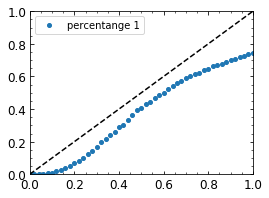

In [24]:
# simple plot for performance result

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 3])
ax.plot(percentage0s, percentage1s, 'o', ms=2**2, color=pp.mplColors[0], label='percentange 1')

ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.legend()
# save
#out_file = 'plot_stats_{:02d}cycle_D{:d}.png'.format(Nmax, int(D))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
#print('saved to file', out_file)
plt.show()